## Data Preprocessing

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Decrease memory needed for data set
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        return df

# Load the dataset
games_df = reduce_memory(pd.read_csv('games.csv'))
games_df = games_df.sample(n=45000, random_state=0)

In [ ]:
import re

# Function to normalize text
def preprocess_text(text):
    text = str(text)  # Ensure text is a string
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation and special characters
    return text

In [7]:
# Fill NaN and drop rows where the Name, About the game, or Tags, column is NaN
games_df = games_df.dropna(subset=['Tags', 'Name', 'About the game', 'Supported languages', 'Genres'])
games_df['Tags'] = games_df['Tags'].fillna('')

# Remove games where English is not a supported language
games_df = games_df[games_df['Supported languages'].str.contains('English', na=False)]

# Remove games that have 0 reviews and 0 playtime
games_df = games_df.drop(games_df.loc[(games_df['Positive'] + games_df['Negative'] == 0) & (games_df['Average playtime forever'] ==  0.0)].index)

# Remove games with 0 estimated owners
games_df = games_df.drop(games_df.loc[games_df['Estimated owners'] == '0-0'].index)

# Ensure the DataFrame is sorted by 'Name'
games_df_sorted = games_df.sort_values(by='Name').reset_index(drop=True)

# Preprocess and combine relevant columns
for column in ['Name', 'Categories', 'Genres', 'Tags', 'About the game']:
    games_df_sorted[column] = games_df_sorted[column].fillna('').apply(preprocess_text)

games_df_sorted['combined_features'] = (
    games_df_sorted['Name'] + ' ' +
    games_df_sorted['Categories'] + ' ' +
    games_df_sorted['Genres'] + ' ' +
    games_df_sorted['Tags'] + ' ' +
    games_df_sorted['About the game']
)
games_df_sorted.info()

<ipython-input-7-c3d55cbab246>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_df['Tags'] = games_df['Tags'].fillna('')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32477 entries, 0 to 32476
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       32477 non-null  int32  
 1   Name                        32477 non-null  object 
 2   Release date                32477 non-null  object 
 3   Estimated owners            32477 non-null  object 
 4   Peak CCU                    32477 non-null  int64  
 5   Required age                32477 non-null  int64  
 6   Price                       32477 non-null  float64
 7   DLC count                   32477 non-null  int64  
 8   About the game              32477 non-null  object 
 9   Supported languages         32477 non-null  object 
 10  Full audio languages        32477 non-null  object 
 11  Reviews                     4913 non-null   object 
 12  Header image                32477 non-null  object 
 13  Website                     174

## Vectorizing Text to Find Important Terms

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define custom stop words
custom_stop_words = ['games', 'game', 'steam']

# Vectorize the combined features column with TF-IDF
tfidf = TfidfVectorizer(stop_words= custom_stop_words + list(TfidfVectorizer(stop_words='english').get_stop_words()), max_features=5000, max_df=0.8, min_df=5)
tfidf_matrix = tfidf.fit_transform(games_df_sorted['combined_features'])

#### Visualizing TF-IDF Feature Importance



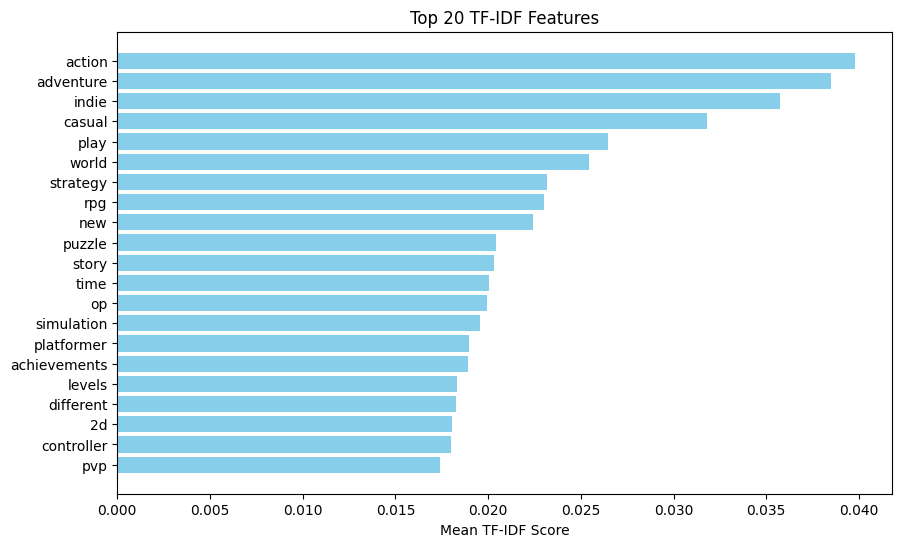

In [9]:
# Get feature names and their importance (mean of TF-IDF scores)
feature_names = tfidf.get_feature_names_out()
importance = np.mean(tfidf_matrix.toarray(), axis=0)

# Get the top 20 features
top_n = 21
indices = np.argsort(importance)[::-1][:top_n]
top_features = [feature_names[i] for i in indices]
top_importance = importance[indices]

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='skyblue')
plt.xlabel('Mean TF-IDF Score')
plt.title('Top 20 TF-IDF Features')
plt.gca().invert_yaxis()
plt.show()

## Computing Cosine Similarity

In [10]:
# Function to compute cosine similarity in chunks
def compute_similarity_in_chunks(matrix, chunk_size=1000):
    n_samples = matrix.shape[0]
    similarity_matrix = np.zeros((n_samples, n_samples))

    for start in range(0, n_samples, chunk_size):
        end = min(start + chunk_size, n_samples)
        chunk = matrix[start:end]
        similarities = linear_kernel(chunk, matrix)
        similarity_matrix[start:end] = similarities

    return similarity_matrix

In [11]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Run calculations
cosine_sim = compute_similarity_in_chunks(tfidf_matrix)

#### Visualizing Cosine Similarity Heatmap

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 30059 (\N{CJK UNIFIED IDEOGRAPH-756B}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25340 (\N{CJK UNIFIED IDEOGRAPH-62FC}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.draw()
/usr

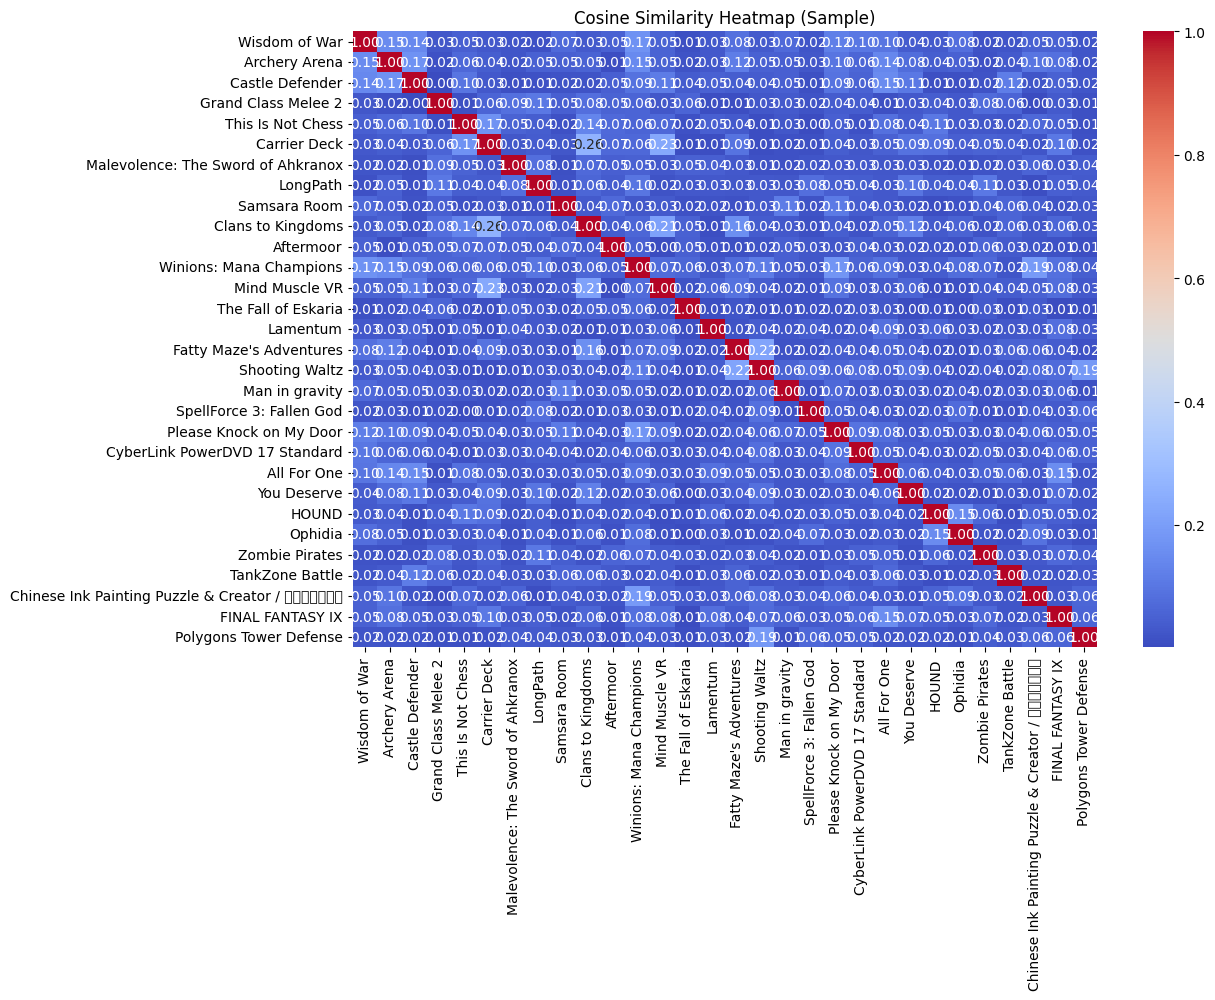

In [12]:
import seaborn as sns

# Sample a subset for better visualization (e.g., first 30 games)
sample_size = 30
cosine_sim_sample = cosine_sim[:sample_size, :sample_size]

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cosine_sim_sample, xticklabels=games_df['Name'][:sample_size], yticklabels=games_df['Name'][:sample_size], cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cosine Similarity Heatmap (Sample)')
plt.show()

## Recommending Games

#### Define functions for game recommendations and visualization

In [13]:
import ipywidgets as widgets
from IPython.display import display

#Construct a reverse map of indices and game titles
indices = pd.Series(games_df_sorted.index, index=games_df_sorted['Name']).drop_duplicates()

# Function to get recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    try:
        # Get the index of the game that matches the title games_df.index[games_df['Name'] == title].tolist()[0]
        idx = games_df_sorted.index[games_df_sorted['Name'] == title].tolist()[0]
        # Get the pairwise similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        # Sort the games based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the indices of the 10 most similar games
        top_10_sim_scores = sim_scores[1:11]
        top_100_sim_scores = sim_scores[1:101]
        top_10_game_indices = [i[0] for i in top_10_sim_scores]
        top_100_game_indices = [i[0] for i in top_100_sim_scores]
        # Return the top 10 most similar games and top 100 game indices
        return games_df_sorted['Name'].iloc[top_10_game_indices], top_10_game_indices, top_100_game_indices, [score for idx, score in top_10_sim_scores]
    except IndexError as e:
        print(f"Error: {e}")
        return [], [], []

# Function to get similarity scores
def get_similarity_scores(picked_game, similarity_matrix, games_df):
    picked_index = indices[picked_game]
    similarity_scores = similarity_matrix[picked_index]
    return similarity_scores

# Function to plot similarity scores and highlight recommended games
def plot_similarity_scores(picked_game, top_10_recommendations, top_10_indices, top_100_indices):
    similarity_scores = get_similarity_scores(picked_game, cosine_sim, games_df_sorted)
    similarity_df = pd.DataFrame({
        'Game Index': games_df_sorted.index,
        'Similarity Score': similarity_scores
    })

    plt.figure(figsize=(10, 6))

    # Plot the 100 closest games in blue
    plt.scatter(similarity_df.loc[top_100_indices, 'Game Index'], similarity_df.loc[top_100_indices, 'Similarity Score'], color='blue')

    # Highlight the recommended games in green
    plt.scatter(similarity_df.loc[top_10_indices, 'Game Index'], similarity_df.loc[top_10_indices, 'Similarity Score'], color='green')

    for idx in top_10_indices:
        plt.text(similarity_df.loc[idx, 'Game Index'], similarity_df.loc[idx, 'Similarity Score'], games_df_sorted['Name'].iloc[idx], fontsize=9, color='green')

    plt.title(f'Similarity Scores of Top 100 Games with "{picked_game}"')
    plt.xlabel('Game Index')
    plt.ylabel('Similarity Score')
    plt.show()

# Visualize similarity percentages
def visualize_similarity_percentage(game_name, recommended_games, similarity_percentages):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=similarity_percentages, y=recommended_games, palette='viridis', hue= recommended_games)
    plt.title(f'Similarity Percentage between "{game_name}" and Recommended Games')
    plt.xlabel('Similarity Percentage')
    plt.ylabel('Recommended Game')
    plt.show()

# Function to display recommendations based on user selection
def display_recommendations(change):
    selected_game = change['new']
    top_10_recommendations, top_10_indices, top_100_indices, similarity_percentages = get_recommendations(selected_game)
    print(f"Recommendations for '{selected_game}':")
    for game in top_10_recommendations:
        print(game)
    plot_similarity_scores(selected_game, top_10_recommendations, top_10_indices, top_100_indices)
    print('\n')
    visualize_similarity_percentage(selected_game, top_10_recommendations, similarity_percentages)

Dropdown(description='Select Game:', options=(' that bastard is trying to steal our gold ', ' anyway ', ' akir…

Recommendations for 'fallout 3':
vault resort
fallout 4
chronicles of mystery secret of the lost kingdom
borderlands 3
silver vault
fallout new vegas
trivia vault technology trivia deluxe
trivia vault science history trivia 2
trivia vault super heroes trivia
anvil


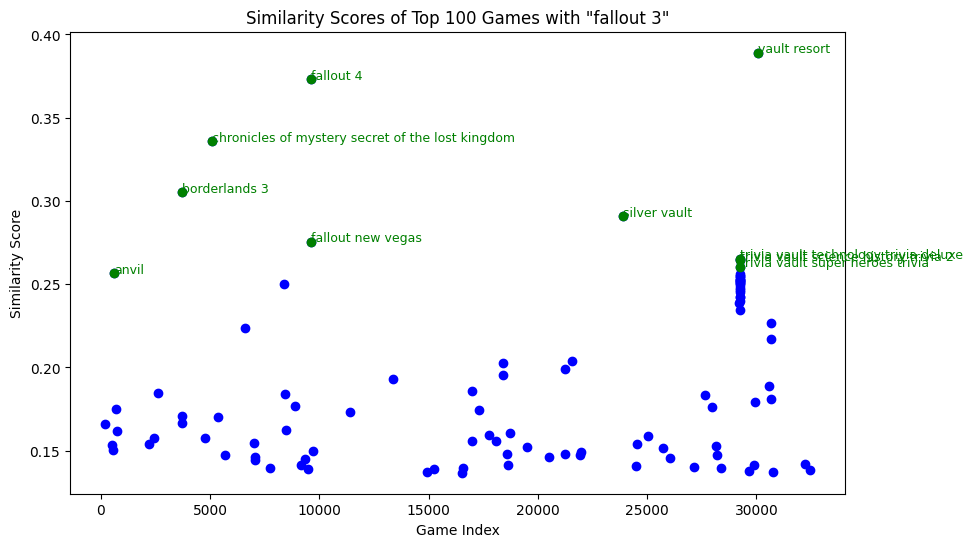

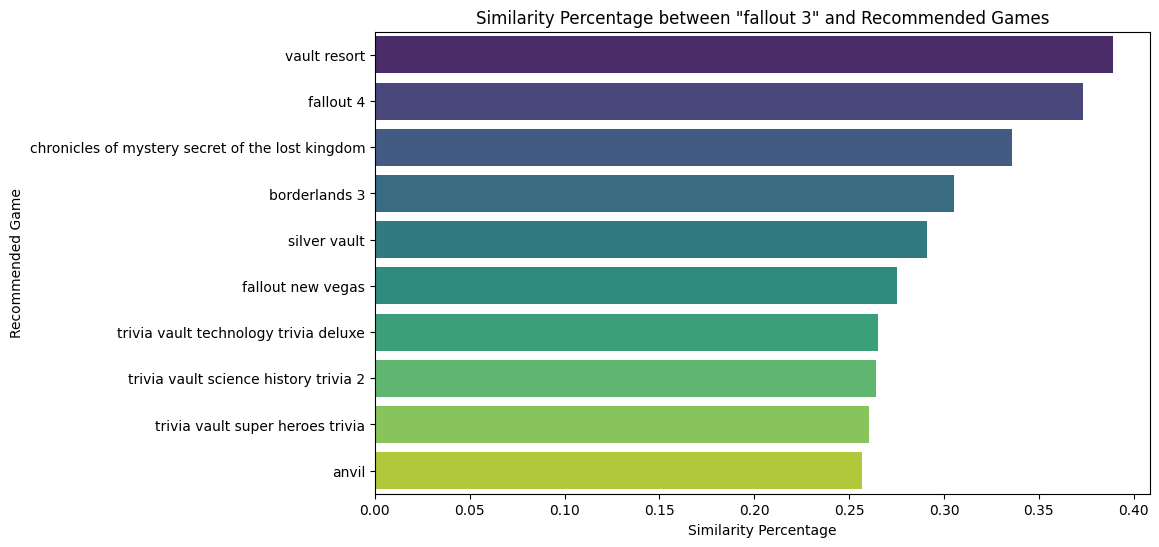

In [15]:
# Create a dropdown widget for user to select a game
game_dropdown = widgets.Dropdown(
    options=games_df_sorted['Name'].unique(),
    description='Select Game:',
    disabled=False,
)

# Link the dropdown to the display function
game_dropdown.observe(display_recommendations, names='value')

# Display the dropdown widget
display(game_dropdown)

In [ ]:
games_df.to_csv('games_df.csv', index=False)